# The Tipping Problem

Note: This method computes everything by hand, step by step. For most people, the new API for fuzzy systems will be preferable. The same problem is solved with the new API in this example.

The ‘tipping problem’ is commonly used to illustrate the power of fuzzy logic principles to generate complex behavior from a compact, intuitive set of expert rules.



Input variables
A number of variables play into the decision about how much to tip while dining. Consider two of them:

*quality* : Quality of the food
*service* : Quality of the service

Output variable
The output variable is simply the tip amount, in percentage points:

*tip* : Percent of bill to add as tip

For the purposes of discussion, let’s say we need ‘high’, ‘medium’, and ‘low’ membership functions for both input variables and our output variable. 

These are defined in scikit-fuzzy as follows

Contents
- The Tipping Problem - The Hard Way
1. Input variables
2. Output variable
3. Fuzzy rules
4. Rule application
5. Rule aggregation
6. Defuzzification
-> The result is a tip of 19.8%.
->Final thoughts

In [1]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt


In [2]:
# Generate universe variables
#   * Quality and service on subjective ranges [0, 10]
#   * Tip has a range of [0, 25] in units of percentage points
x_qual = np.arange(0, 11, 1)
x_serv = np.arange(0, 11, 1)
x_tip  = np.arange(0, 26, 1)

In [4]:
print(x_qual)
print(x_serv)
print(x_tip)

[ 0  1  2  3  4  5  6  7  8  9 10]
[ 0  1  2  3  4  5  6  7  8  9 10]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [9]:
# Generate fuzzy membership functions
# -- Quality
qual_lo = fuzz.trimf(x_qual, [0, 0, 5])
qual_md = fuzz.trimf(x_qual, [0, 5, 10])
qual_hi = fuzz.trimf(x_qual, [5, 10, 10])
# -- Serve
serv_lo = fuzz.trimf(x_serv, [0, 0, 5])
serv_md = fuzz.trimf(x_serv, [0, 5, 10])
serv_hi = fuzz.trimf(x_serv, [5, 10, 10])
# -- Tips
tip_lo = fuzz.trimf(x_tip, [0, 0, 13])
tip_md = fuzz.trimf(x_tip, [0, 13, 25])
tip_hi = fuzz.trimf(x_tip, [13, 25, 25])


In [118]:
rate = max(x_tip)/max(max(x_serv), max(x_qual))

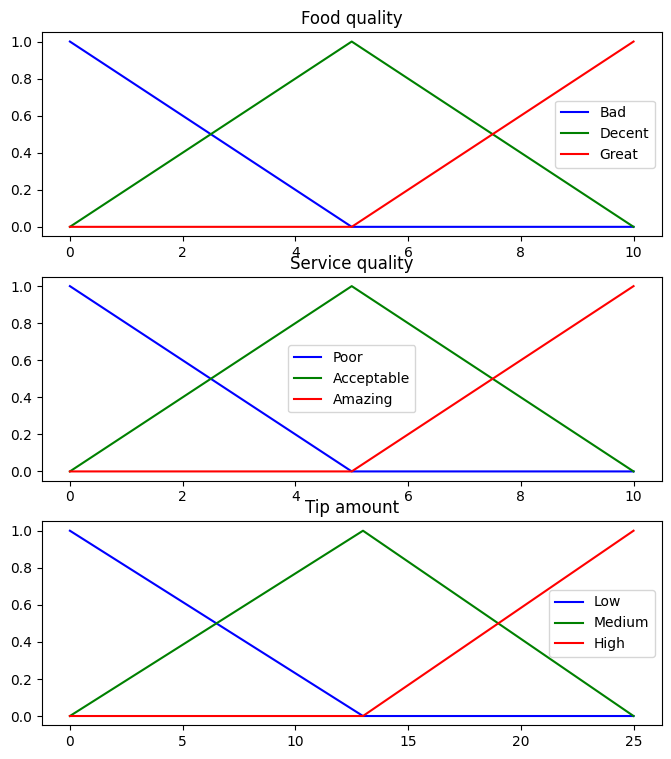

In [12]:
# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_qual, qual_lo, 'b', linewidth=1.5, label='Bad')
ax0.plot(x_qual, qual_md, 'g', linewidth=1.5, label='Decent')
ax0.plot(x_qual, qual_hi, 'r', linewidth=1.5, label='Great')
ax0.set_title('Food quality')
ax0.legend()

ax1.plot(x_serv, serv_lo, 'b', linewidth=1.5, label='Poor')
ax1.plot(x_serv, serv_md, 'g', linewidth=1.5, label='Acceptable')
ax1.plot(x_serv, serv_hi, 'r', linewidth=1.5, label='Amazing')
ax1.set_title('Service quality')
ax1.legend()

ax2.plot(x_tip, tip_lo, 'b', linewidth=1.5, label='Low')
ax2.plot(x_tip, tip_md, 'g', linewidth=1.5, label='Medium')
ax2.plot(x_tip, tip_hi, 'r', linewidth=1.5, label='High')
ax2.set_title('Tip amount')
ax2.legend()

In [13]:
# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

# Fuzzy rules
Now, to make these triangles useful, we define the fuzzy relationship between input and output variables. For the purposes of our example, consider three simple rules:

- If the food is bad OR the service is poor, then the tip will be low
- If the service is acceptable, then the tip will be medium
- If the food is great OR the service is amazing, then the tip will be high.

Most people would agree on these rules, but the rules are fuzzy. Mapping the imprecise rules into a defined, actionable tip is a challenge. This is the kind of task at which fuzzy logic excels.


* Rule application
What would the tip be in the following circumstance:

- Food quality was 6.5
- Service was 9.8

In [137]:
def find_tip_area(quality_value, service_value):
    # We need the activation of our fuzzy membership functions at these values.
    # The exact values 6.5 and 9.8 do not exist on our universes...
    # This is what fuzz.interp_membership exists for!
    qual_level_lo = fuzz.interp_membership(x_qual, qual_lo, quality_value)
    qual_level_md = fuzz.interp_membership(x_qual, qual_md, quality_value)
    qual_level_hi = fuzz.interp_membership(x_qual, qual_hi, quality_value)

    serv_level_lo = fuzz.interp_membership(x_serv, serv_lo, service_value)
    serv_level_md = fuzz.interp_membership(x_serv, serv_md, service_value)
    serv_level_hi = fuzz.interp_membership(x_serv, serv_hi, service_value)

    # Now we take our rules and apply them. Rule 1 concerns bad food OR service.
    # The OR operator means we take the maximum of these two.
    active_rule1 = np.fmax(qual_level_lo, serv_level_lo)

    # Now we apply this by clipping the top off the corresponding output
    # membership function with `np.fmin`
    tip_activation_lo = np.fmin(active_rule1, tip_lo)  # removed entirely to 0

    # For rule 2 we connect acceptable service to medium tipping
    tip_activation_md = np.fmin(serv_level_md, tip_md)

    # For rule 3 we connect high service OR high food with high tipping
    active_rule3 = np.fmax(qual_level_hi, serv_level_hi)
    tip_activation_hi = np.fmin(active_rule3, tip_hi)
    tip0 = np.zeros_like(x_tip)

    # Visualize this
    fig, ax0 = plt.subplots(figsize=(8, 3))

    ax0.fill_between(x_tip, tip0, tip_activation_lo, facecolor='b', alpha=0.7)
    ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
    ax0.fill_between(x_tip, tip0, tip_activation_md, facecolor='g', alpha=0.7)
    ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
    ax0.fill_between(x_tip, tip0, tip_activation_hi, facecolor='r', alpha=0.7)
    ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')

    ax0.plot([quality_value * rate, quality_value * rate], [0, 1], 'Blue', linewidth=2.5, alpha=0.9, label='Quality')
    ax0.plot([service_value * rate, service_value * rate], [0, 1], 'Green', linewidth=2.5, alpha=0.9, label='Service')

    ax0.set_title('Output membership activity')
    ax0.legend()

    # Turn off top/right axes
    for ax in (ax0,):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()

    plt.tight_layout()
    return (tip_activation_lo, tip_activation_md, tip_activation_hi, tip0)

In [138]:
def find_tip(quality_value, service_value, tip_activation_lo, tip_activation_md, tip_activation_hi, tip0):
        # Aggregate all three output membership functions together
    aggregated = np.fmax(tip_activation_lo,
                        np.fmax(tip_activation_md, tip_activation_hi))

    # Calculate defuzzified result
    tip = fuzz.defuzz(x_tip, aggregated, 'centroid')
    tip_activation = fuzz.interp_membership(x_tip, aggregated, tip)  # for plot

    # Visualize this
    fig, ax0 = plt.subplots(figsize=(8, 3))

    ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
    ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
    ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
    ax0.fill_between(x_tip, tip0, aggregated, facecolor='Orange', alpha=0.7)
    ax0.plot([tip, tip], [0, tip_activation], 'Red', linewidth=1.5, alpha=0.9, label='Tip')

    ax0.plot([quality_value * rate, quality_value * rate], [0, tip_activation], 'Blue', linewidth=2.5, alpha=0.9, label='Quality')
    ax0.plot([service_value * rate, service_value * rate], [0, tip_activation], 'Green', linewidth=2.5, alpha=0.9, label='Service')
    ax0.set_title('Aggregated membership and result (line)')
    ax0.legend()

    # Turn off top/right axes
    for ax in (ax0,):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()

    plt.tight_layout()   
    return tip                          

Tip activation: 19.86871794871795 (%)


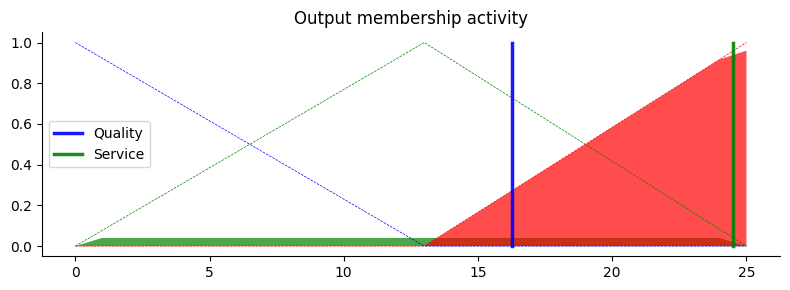

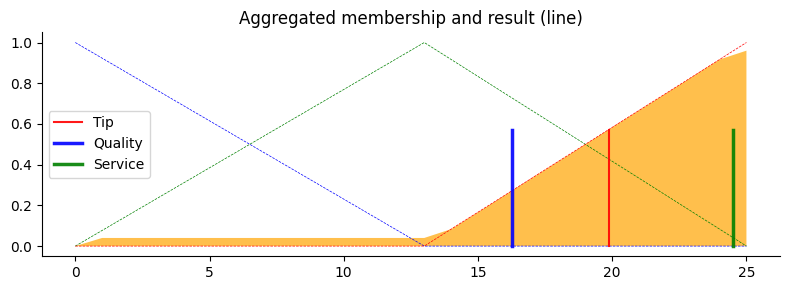

In [144]:
quality_value=6.5
service_value=9.8
tip_activation_lo, tip_activation_md, tip_activation_hi, tip0 = find_tip_area(quality_value, service_value)
tip = find_tip(quality_value, service_value, tip_activation_lo, tip_activation_md, tip_activation_hi, tip0)
print("Tip activation: {0} (%)".format(tip))

Tip activation: 4.333333333333333 (%)


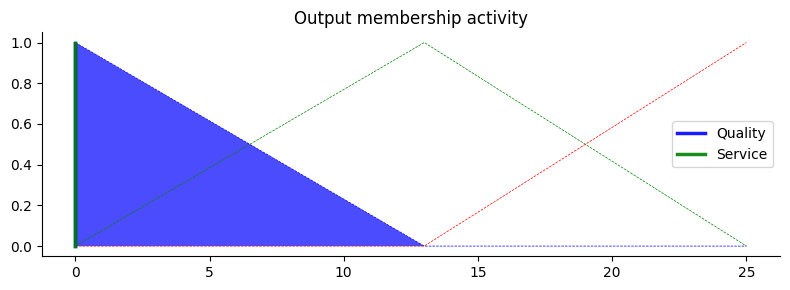

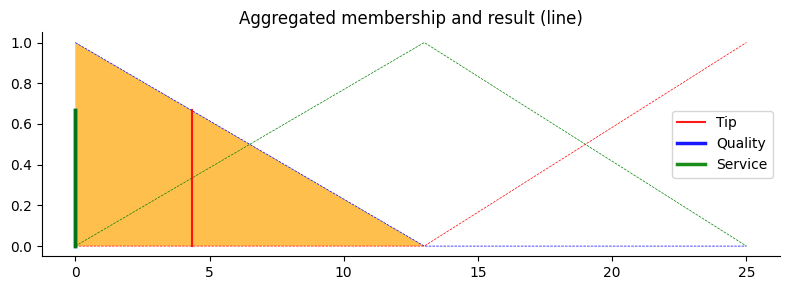

In [145]:
quality_value=0
service_value=0
tip_activation_lo, tip_activation_md, tip_activation_hi, tip0 = find_tip_area(quality_value, service_value)
tip = find_tip(quality_value, service_value, tip_activation_lo, tip_activation_md, tip_activation_hi, tip0)
print("Tip activation: {0} (%)".format(tip))